In [1]:
using DrWatson

@quickactivate "GRNEvoContingency"

projectname()

"GRNEvoContingency"

In [2]:
include(srcdir("TissueModel_ND.jl"))

include(srcdir("Evolution.jl"))
include(srcdir("FitnessFunctions.jl"))

include(srcdir("NetworkTopologies.jl"))
include(srcdir("Utility.jl"))

using Plots
using Random
using Parameters
using Printf
using DataFrames
using StatsPlots
using Distances

using Base.Threads
using Base.Threads: @spawn

example_networks = load(datadir("exp_pro/80-40-80_networks/examples.jld"))
df = collect_results(datadir("sims/repeated_evolution_different_topologies"));

┌ Info: Scanning folder /Users/boothh/Documents/GRNEvoContingency/data/sims/repeated_evolution_different_topologies for result files.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:115
┌ Info: Added 4 entries.
└ @ DrWatson /Users/boothh/.julia/packages/DrWatson/UkasH/src/result_collection.jl:191


In [3]:
headings = ["topology",
            "target",
            "n_traj",
            "max_gen",
            "β",
            "noise_cv",
            "mutation_method",
            "noise_method",
            "n_max_iters_reached",
            "describe_proportion_mutants_rejected"];

df[:,headings]

Row,topology,target,n_traj,max_gen,β,noise_cv,mutation_method,noise_method,n_max_iters_reached,describe_proportion_mutants_rejected
,String?,Array…?,Int64?,Int64?,Float64?,Float64?,String?,String?,Int64?,SummaryS…?
1,classical,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.018348\nMinimum: 0.001850\n1st Quartile: 0.012676\nMedian: 0.016801\n3rd Quartile: 0.020967\nMaximum: 0.075696\n
2,feed_forward,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.019802\nMinimum: 0.000000\n1st Quartile: 0.000669\nMedian: 0.012043\n3rd Quartile: 0.035063\nMaximum: 0.097395\n
3,mutual_inh,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.020275\nMinimum: 0.001313\n1st Quartile: 0.017634\nMedian: 0.020514\n3rd Quartile: 0.023056\nMaximum: 0.032863\n
4,overlap_dom,"[(40.0, 20.0)]",100,20000,Inf,1.0,all_viable,additive,0,Summary Stats:\nLength: 100\nMissing Count: 0\nMean: 0.012762\nMinimum: 0.000000\n1st Quartile: 0.000366\nMedian: 0.004846\n3rd Quartile: 0.017632\nMaximum: 0.240788\n


In [4]:
evolutionary_runs = Dict{String,Any}("classical"=>df[:,"raw_data"][1],"feed_forward"=>df[:,"raw_data"][2],"mutual_inh"=>df[:,"raw_data"][3],"overlap_dom"=>df[:,"raw_data"][4]);

In [5]:
topology = "overlap_dom"
start_network = example_networks[topology]
run_data = evolutionary_runs[topology];

In [32]:
start_phenotype = run_data[1][2].traversed_phenotypes[1][1]

(99.5, 19.5)

In [6]:
grn_parameters = DefaultGRNParameters()

p = (start_network,grn_parameters.degradation)
    
grn = ODEProblem(gene_regulation_1d!,grn_parameters.g0,(0,Inf),p)

development = DefaultGRNSolver()

founder = Individual(grn,development);

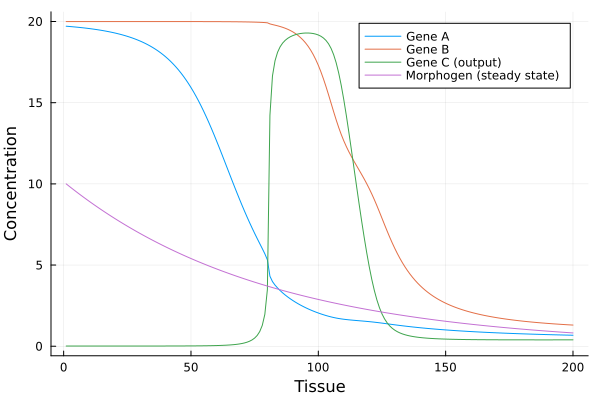

In [7]:
plot_SS(founder.phenotype.u[end])

In [8]:
noise_application = (x,n) -> x + x*n  

function increment_weight(choice,val,noise_application,w)
    new_w = copy(w)
    new_w[choice...] = noise_application(new_w[choice...],val)
    return new_w
end

increment_weight (generic function with 1 method)

In [9]:
n_stripe = 1

stripe_threshold = 5.

min_width = 5.

output_gene = 3

target = [(40.,20.)]

fitness_function = s -> fitness_evaluation(s,x->f_sim_cw(x,stripe_threshold,n_stripe,target,min_width),output_gene)

#31 (generic function with 1 method)

In [10]:
function create_mutant_get_fitness(founder,development,fitness_function,noise_application,entry,step)

    mutant = create_mutant(founder,x->increment_weight(entry,step,noise_application,x),development)

    mutant_fitness,mutant_pheno_class = fitness_function(mutant.phenotype)

    if mutant_fitness[1] == 0.
        actual_fitness = -mutant_fitness[2]
    else
        actual_fitness = -Inf
    end

    return actual_fitness

end

create_mutant_get_fitness (generic function with 1 method)

In [11]:
current_fitness,class = fitness_function(founder.phenotype);

In [12]:
current_fitness[2]

3540.5

In [13]:
entry = (3,2)

N_sample = 1000

sample_steps = range(-1,1,length = N_sample)

all_fitnesses = zeros(N_sample)

@sync for i in 1:length(sample_steps)
    @spawn all_fitnesses[i] = create_mutant_get_fitness(founder,development,fitness_function,noise_application,entry,sample_steps[i])
end

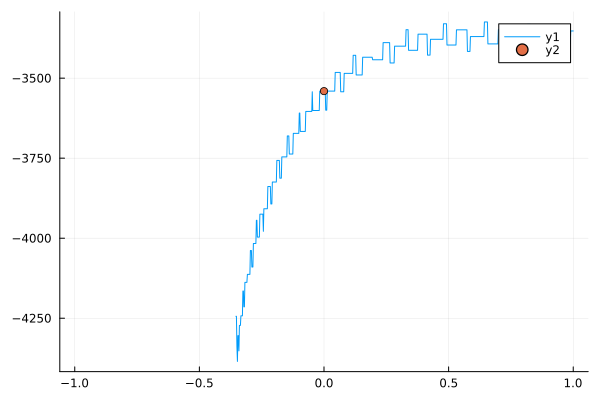

In [14]:
p = plot(sample_steps,all_fitnesses)
scatter!(p,(0.,-current_fitness[2]))

In [15]:
N_sample = 1000

sample_steps = range(-3,3,length = N_sample)

results = Dict()

for i in 1:size(start_network,1)
    for j in 1:size(start_network,2)

        all_fitnesses = zeros(N_sample)

        @sync for s in 1:length(sample_steps)
            @spawn all_fitnesses[s] = create_mutant_get_fitness(founder,development,fitness_function,noise_application,(i,j),sample_steps[s])
        end

        results[(i,j)] = all_fitnesses
    end
end    

In [16]:
function improvement_intervals(fitnesses,cf)

    less_than = fitnesses .> cf

    index_less = findall(x-> x,less_than)

    if length(index_less) > 2
    
        start = index_less[1]
        
        mass = 0.
        
        for i in 1:length(index_less)-1
        
            if index_less[i] + 1 > index_less[i+1] 
        
                mass += cdf(noise_dist,sample_steps[index_less[i]]) - cdf(noise_dist,sample_steps[start])
        
                start = index_less[i+1] 
        
            # elseif i+1 == length(index_less)-1
        
            #     mass += cdf(noise_dist,sample_steps[index_less[i+1]]) - cdf(noise_dist,sample_steps[start])
            # end
            end
        
        end
        
        mass += cdf(noise_dist,sample_steps[index_less[end]]) - cdf(noise_dist,sample_steps[start])

    else
        mass = 0.
    end

    return mass,index_less
end

improvement_intervals (generic function with 1 method)

In [46]:
plot_list = []

noise_dist = Normal(0.,1.)

sum_mass = 0.

matrix_entries = [(1,1),(1,2),(1,3),(1,4),(2,1),(2,2),(2,3),(2,4),(3,1),(3,2),(3,3),(3,4)]

masses = Dict()

for entry in matrix_entries

    data = results[entry]

    mass,index_less = improvement_intervals(data,-current_fitness[2])

    masses[entry] = mass

    sum_mass += mass

    p = plot(sample_steps,data, title = string(entry) * " - Successful mutation probability = " * string(round(mass,digits =3)),label = "Fitness, F",titlefontsize = 8.)
    
    plot!(twinx(),sample_steps,pdf.(noise_dist,collect(sample_steps)), color = :red, label = nothing)
    plot!(twinx(),sample_steps[index_less], pdf.(noise_dist,sample_steps[index_less]), fillrange = zero(sample_steps[index_less]), fc=:reds,fillalpha = 0.2,yaxis = nothing, label = nothing, linealpha = 0.)
    scatter!(p,(0.,-current_fitness[2]), label = "Start")
    hline!(p,[-current_fitness[2]],label = nothing)

    # if length(index_less) > 0
    #     # x_annotate = sample_steps[index_less[Int(floor(length(index_less)/2))]]
    #     y_annotate = (minimum(data) + -current_fitness[2]) / 2
    #     annotate!(p,0.,y_annotate,string(sum_mass))
    # end

    push!(plot_list,p)

end

p_selection = 0.1

average_mass = p_selection*sum_mass # probability of transition to new genotype if at g_start

prob_mutation = Dict()

for (t,m) in masses

    prob_mutation[t] = p_selection*m
end


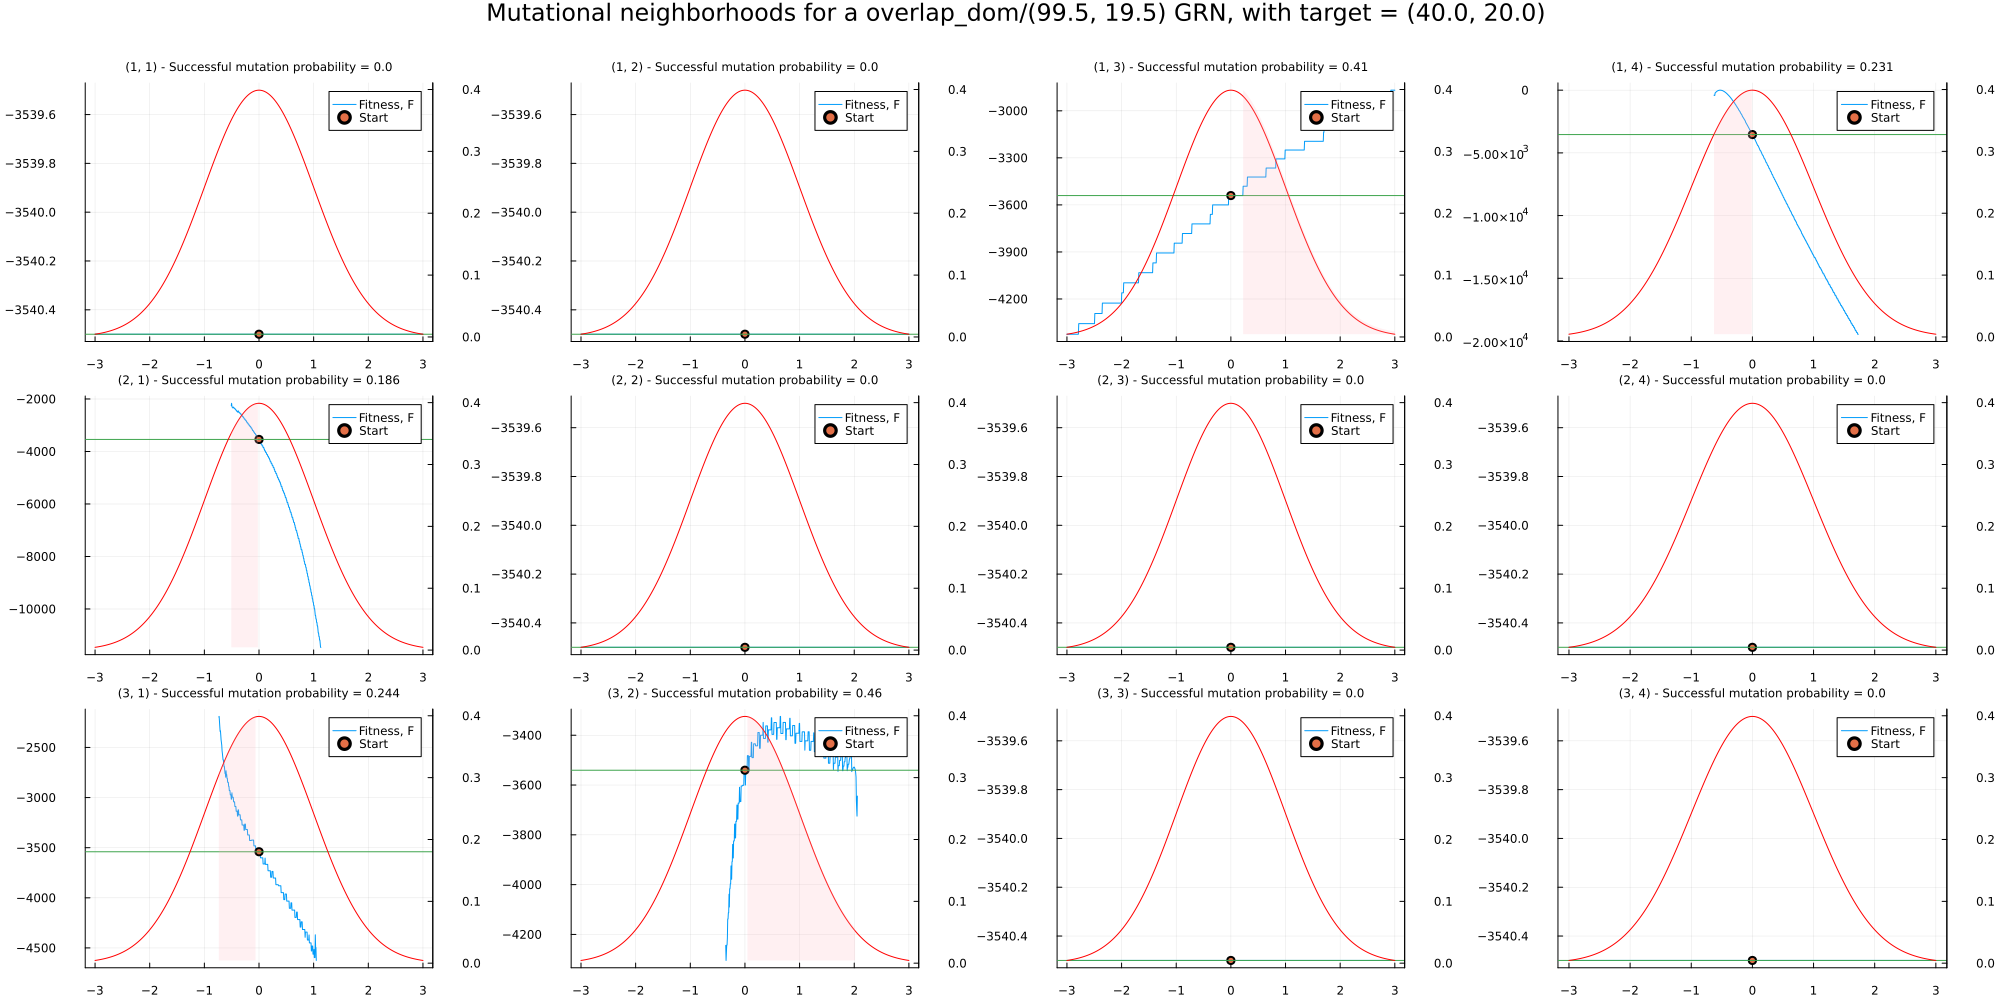

In [47]:
plot(plot_list..., size = (2000,1000),layout = (3,4),plot_title = "Mutational neighborhoods for a " * topology * "/" * string(start_phenotype) * " GRN, with target = " * string(target[1]),margin = 100*Plots.mm)

In [45]:
# x -> x+ x*n stops zero edge 
# beta would change picture -> much smaller probability for those omly offering marginal improvement

# Hypothesis: paths through genotype space get less diverse as we decrease beta from Inf, i.e. it will increasingly go from "take any with imporvement" to "take only the ones with significant improvement"

In [48]:
prob_mutation

Dict{Any, Any} with 12 entries:
  (1, 2) => 0.0
  (3, 1) => 0.0243912
  (1, 3) => 0.0409552
  (1, 4) => 0.0231282
  (3, 2) => 0.0460084
  (3, 3) => 0.0
  (2, 1) => 0.0185715
  (3, 4) => 0.0
  (2, 2) => 0.0
  (2, 3) => 0.0
  (2, 4) => 0.0
  (1, 1) => 0.0

In [54]:
first_w_mutants = map(x->x[2].traversed_topologies[1:2],run_data);

In [56]:
first_w_mutants[1]

2-element Vector{Matrix{Float64}}:
 [0.0 0.0 -0.0037946873672191623 0.22821365435451213; 0.653414941936679 0.0 0.0 0.0; -0.42453295521991624 0.1500293447611271 0.0 0.0]
 [0.0 0.0 -0.0037946873672191623 0.22821365435451213; 0.653414941936679 0.0 0.0 0.0; -0.42453295521991624 0.1500293447611271 0.0 0.0]

In [59]:
function find_difference(top_list)

    a =  top_list[1]
    b = top_list[2]

    changes =  []

    for i in 1:size(a,1)
        for j in 1:size(a,2)
            if a[i,j] != b[i,j]
                push!(changes,(i,j))
            end
        end
    end

    return changes
end

find_difference (generic function with 1 method)

In [61]:
countmap(map(x->find_difference(x),first_w_mutants))

Dict{Vector{Any}, Int64} with 2 entries:
  []                                       => 95
  [(1, 3), (1, 4), (2, 1), (3, 1), (3, 2)] => 5